# Depedencies

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Image and Mask

In [2]:
train_files = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train = i.replace('_mask','')
    train_files.append(train)

# Visualization

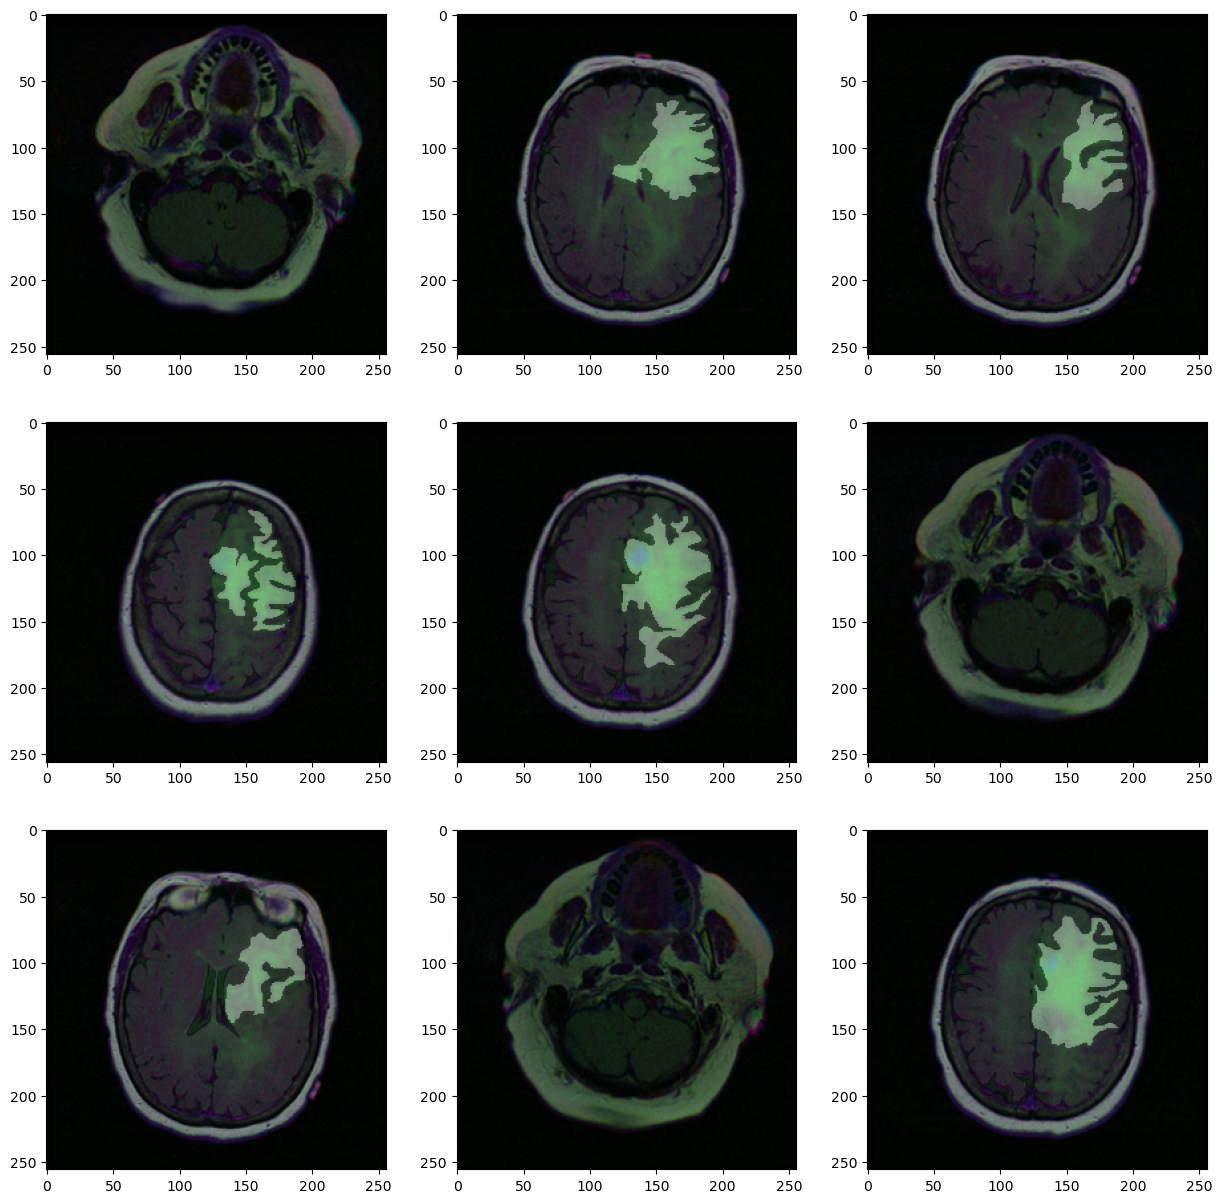

In [3]:
rows, cols = 3,3
fig = plt.figure(figsize=(15,15))

for i in range(1, rows*cols+1):
  fig.add_subplot(rows, cols, i)
  img_path = train_files[i]
  msk_path = mask_files[i]

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  msk = cv2.imread(msk_path)

  plt.imshow(img)
  plt.imshow(msk, alpha=0.3)
plt.show()

# Create Dataframe and split to train,test,validation

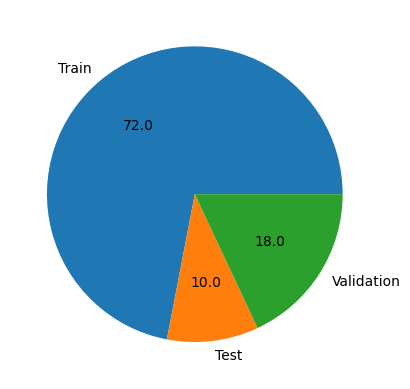

In [4]:
# Dataframe containing two columns, train files and mask
df = pd.DataFrame(data={"filename":train_files,
                        "mask":mask_files})

df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)

plt.pie([len(df_train),len(df_test),len(df_val)], labels=['Train','Test','Validation'], autopct="%.1f")
plt.show()

# Data Generator

In [5]:
##################### SCALE IMAGE #####################
def adjust_data(img, mask):
  img = img / 255
  mask = mask / 255
  mask[mask > 0.5] = 1
  mask[mask <= 0.5] = 0
  return (img, mask)

##################### IMAGE AUGMENTATION FUNCTION #####################
def train_generator(data_frame,
                    batch_size,
                    aug_dict,
                    image_color_mode='rgb',
                    mask_color_mode='grayscale',
                    image_save_prefix='image',
                    mask_save_prefix='mask',
                    save_to_dir=None,
                    target_size=(256,256),
                    seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(data_frame,
                                                        x_col='filename',
                                                        class_mode=None,
                                                        color_mode=image_color_mode,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        save_to_dir=save_to_dir,
                                                        save_prefix=image_save_prefix,
                                                        seed=seed)

    mask_generator = mask_datagen.flow_from_dataframe(data_frame,
                                                    x_col='mask',
                                                    class_mode=None,
                                                    color_mode=mask_color_mode,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    save_to_dir=save_to_dir,
                                                    save_prefix=mask_save_prefix,
                                                    seed=seed)
    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

# Loss Functions and Metrics

\begin{align}
        IoU = \frac{Intersection}{Union} = \frac{TP}{FP+TP+FN}
\end{align}
<br><br>
\begin{align}
        Dice = \frac{2\times Intersection}{Union+Intersection}
\end{align}
<br><br>
\begin{align}
        Dice Loss = 1 - \frac{2\times Intersection}{Union+Intersection}
\end{align}

In [6]:
def dice_coef(y_true, y_pred):
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred) 
  coef = ((2 *intersection) / (K.sum(y_true) + K.sum(y_pred)))
  return coef 

def dice_loss(y_true, y_pred): 
  return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred): 
  intersection = K.sum(y_true * y_pred) 
  iou_score = intersection / ((K.sum(y_true + y_pred)) - intersection)
  return iou_score 

# Model

In [7]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

# HyperParameter

In [8]:
#parameter
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

#image size
im_width = 256
im_height = 256

# Use the Generator

In [9]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train,
                            BATCH_SIZE,
                            train_generator_args,
                            target_size=(im_height,im_width))

In [10]:
test_gen = train_generator(df_val,
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height,im_width))

# Training

In [11]:
model = unet(input_size=(im_height, im_width, 3))

In [12]:
decay_rate = learning_rate / EPOCHS
opt = tf.keras.optimizers.legacy.Adam(lr=learning_rate,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=None,
                                      decay=decay_rate,
                                      amsgrad=False)

callbacks = [ModelCheckpoint('brain_mri.hdf5', verbose=1, save_best_only=True)]

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.compile(optimizer=opt, loss=dice_loss, metrics=["binary_accuracy", iou, dice_coef])

In [14]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: -1s - loss: 0.8653 - binary_accuracy: 0.9191 - iou: 0.0746 - dice_coef: 0.1359Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.97634, saving model to brain_mri.hdf5
88/88 [==============================] - 235s 2s/step - loss: 0.8653 - binary_accuracy: 0.9191 - iou: 0.0746 - dice_coef: 0.1359 - val_loss: 0.9763 - val_binary_accuracy: 0.9911 - val_iou: 0.0129 - val_dice_coef: 0.0254
Epoch 2/150
89/88 [==============================] - ETA: -1s - loss: 0.7508 - binary_accuracy: 0.9879 - iou: 0.1441 - dice_coef: 0.2491
Epoch 2: val_loss did not improve from 0.97634
88/88 [==============================] - 159s 2s/step - loss: 0.7508 - binary_accuracy: 0.9879 - iou: 0.1441 - dice_coef: 0.2491 - val_loss: 0.9825 - val_binary_accuracy: 0.9900 - val_iou: 0.0089 - val_dice_coef: 0.0176
Epoch 3/15

# Graph the Loss, IoU, and Dice

In [30]:
def draw_graph(train,test,train_label="train_label",test_label="test_label",title="title",ax=None):
    ax.plot(train, label=train_label)
    ax.plot(test, label=test_label)
    ax.set_title(title)
    ax.legend()

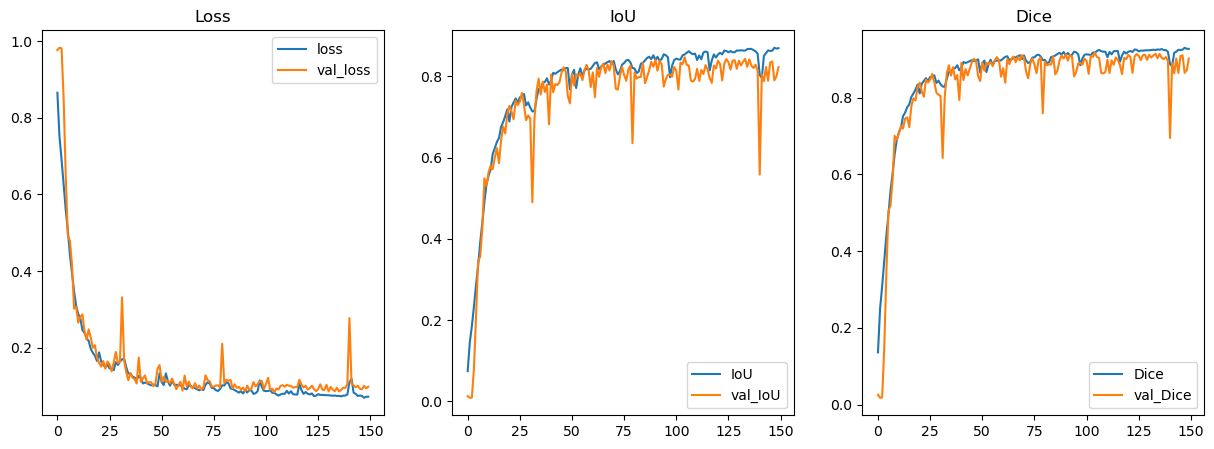

In [35]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

draw_graph(history.history['loss'],history.history['val_loss'],"loss","val_loss","Loss",ax=ax[0])
draw_graph(history.history['iou'],history.history['val_iou'],"IoU","val_IoU","IoU",ax=ax[1])
draw_graph(history.history['dice_coef'],history.history['val_dice_coef'],"Dice","val_Dice","Dice",ax=ax[2])

In [36]:
test_gen = train_generator(df_test,
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps=len(df_test)/BATCH_SIZE)
print("loss: ",results[0])
print("IOU: ",results[1])
print("Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 13s 1s/step - loss: 0.1066 - binary_accuracy: 0.9980 - iou: 0.8127 - dice_coef: 0.8955
loss:  0.10664565861225128
IOU:  0.9980469346046448
Dice Coefficent:  0.8127251863479614


# Test

1/1 [==============================] - 2s 2s/step


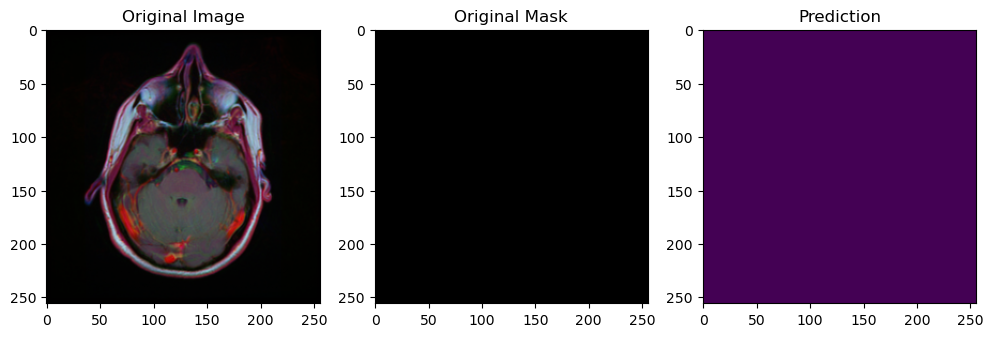

1/1 [==============================] - 0s 23ms/step


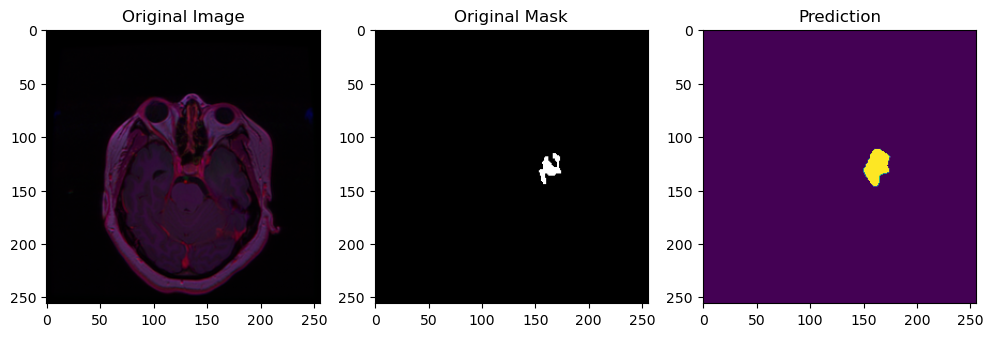

1/1 [==============================] - 0s 24ms/step


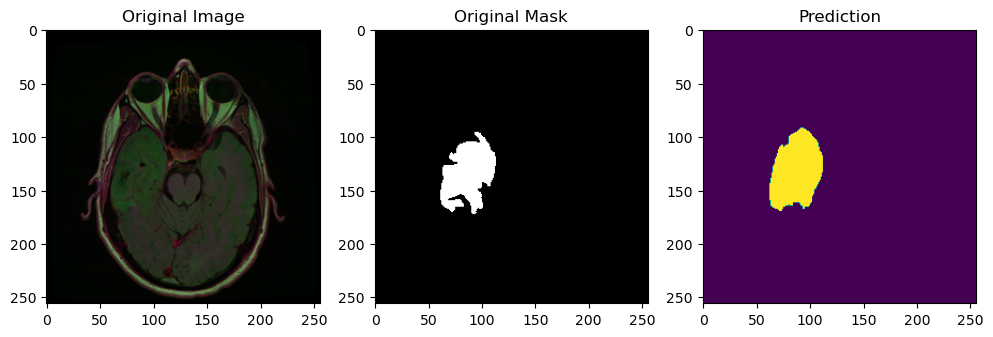

1/1 [==============================] - 0s 23ms/step


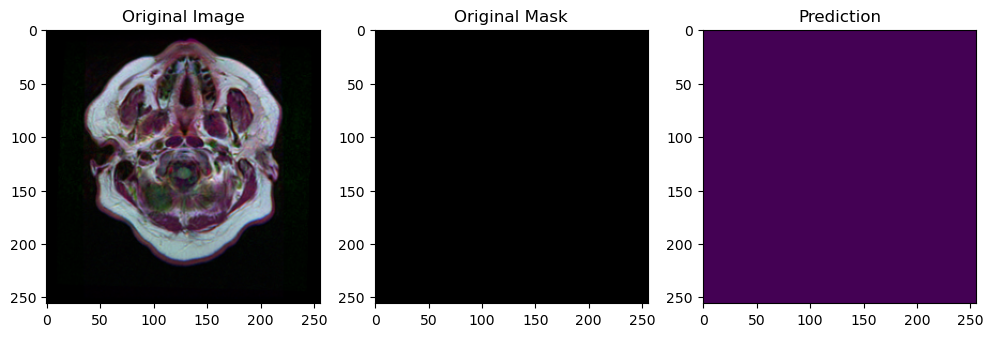

1/1 [==============================] - 0s 24ms/step


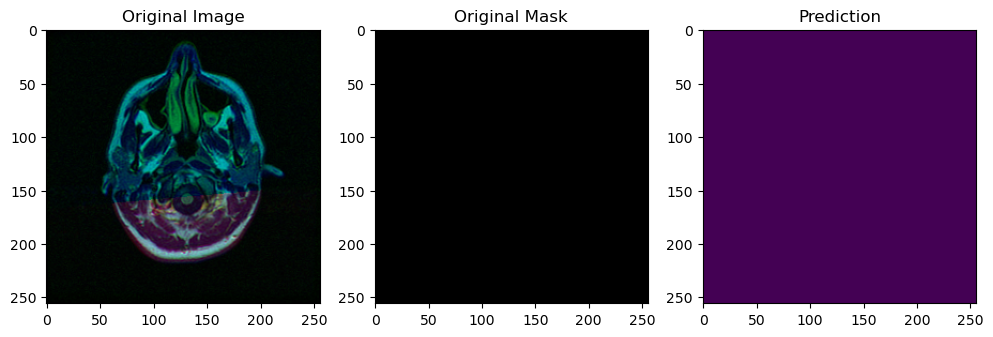

1/1 [==============================] - 0s 22ms/step


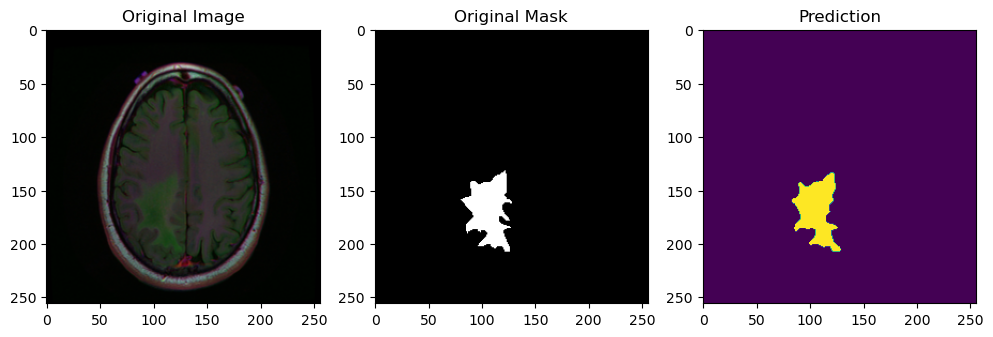

1/1 [==============================] - 0s 21ms/step


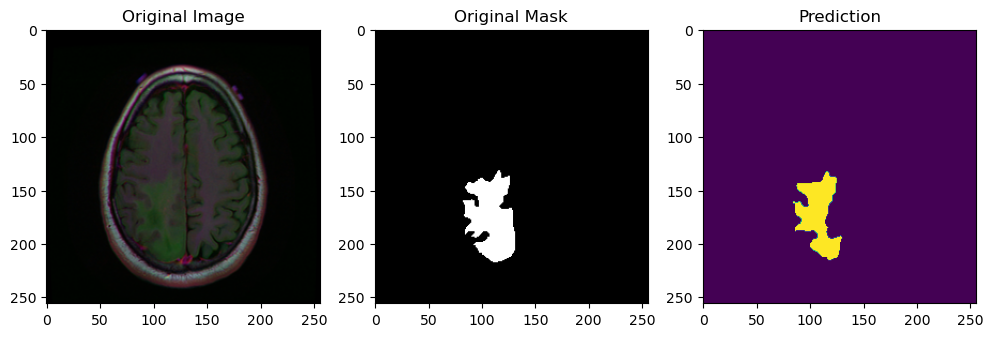

1/1 [==============================] - 0s 23ms/step


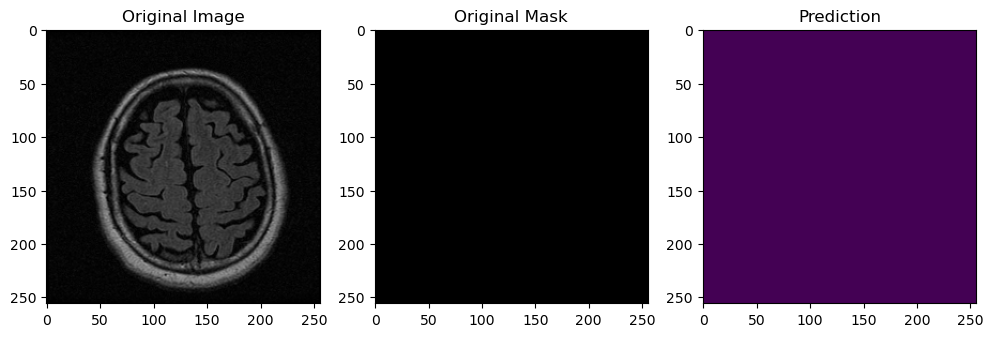

1/1 [==============================] - 0s 24ms/step


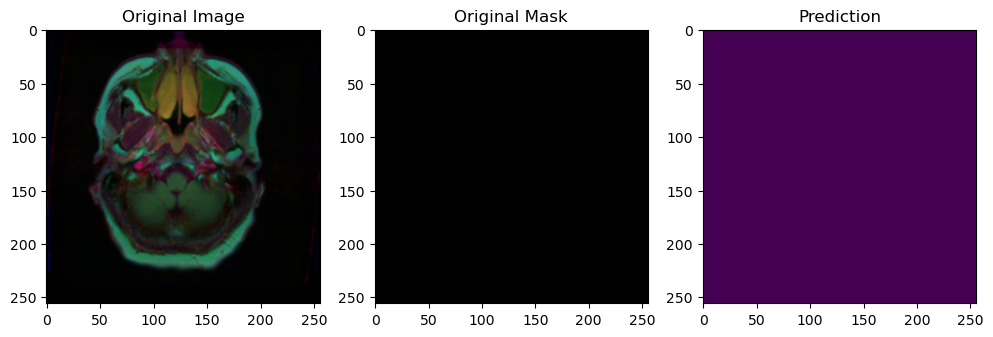

1/1 [==============================] - 0s 22ms/step


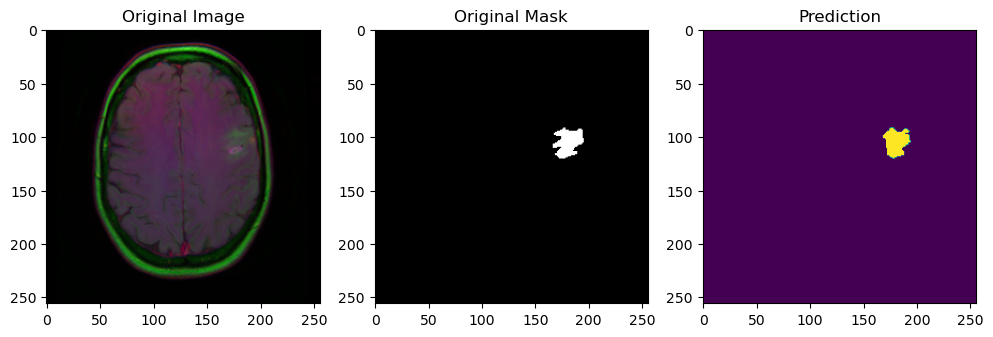

In [37]:
for i in range(10):
  index = np.random.randint(1, len(df_test.index))

  img = cv2.imread(df_test['filename'].iloc[index])
  img = cv2.resize(img, (im_height, im_width))
  img = img / 255
  img = img[np.newaxis, :, :, :]
  pred = model.predict(img)

  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
  plt.title('Original Mask')
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred) > .5)
  plt.title('Prediction')
  plt.show()